<a href="https://colab.research.google.com/github/ayushiiii28/Intent-code/blob/main/user_intenr_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn umap-learn sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [10]:
import pandas as pd

df = pd.read_csv("/content/data.csv")  # Modify path as needed
queries = df.iloc[:, 0].dropna().astype(str).tolist()
df.head()


,sentence
0,You guys provide EMI option?
1,Do you offer Zero Percent EMI payment options?
2,0% EMI.
3,EMI
4,I want in installment


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(queries)

# Clustering
kmeans_tfidf = KMeans(n_clusters=8, random_state=42)
labels_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

# Evaluation
score_tfidf = silhouette_score(X_tfidf, labels_tfidf)
print(f"[TF-IDF + KMeans] Silhouette Score: {score_tfidf:.3f}")



[TF-IDF + KMeans] Silhouette Score: 0.042


In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
X_sbert = model.encode(queries, show_progress_bar=True)

# Clustering
kmeans_sbert = KMeans(n_clusters=8, random_state=42)
labels_sbert = kmeans_sbert.fit_predict(X_sbert)

# Evaluation
score_sbert = silhouette_score(X_sbert, labels_sbert)
print(f"[SBERT + KMeans] Silhouette Score: {score_sbert:.3f}")



Batches:   0%|          | 0/11 [00:00<?, ?it/s]

[SBERT + KMeans] Silhouette Score: 0.104


In [14]:
import hdbscan

# Clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels_hdb = hdb.fit_predict(X_sbert)

# Remove noise labels (-1) for evaluation
filtered_labels = [l for l in labels_hdb if l != -1]
filtered_embeddings = [X_sbert[i] for i in range(len(labels_hdb)) if labels_hdb[i] != -1]

# Evaluation
if len(set(filtered_labels)) > 1:
    score_hdb = silhouette_score(filtered_embeddings, filtered_labels)
    print(f"[SBERT + HDBSCAN] Silhouette Score (excluding noise): {score_hdb:.3f}")
else:
    print("[SBERT + HDBSCAN] Not enough clusters formed for Silhouette Score.")


[SBERT + HDBSCAN] Silhouette Score (excluding noise): 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


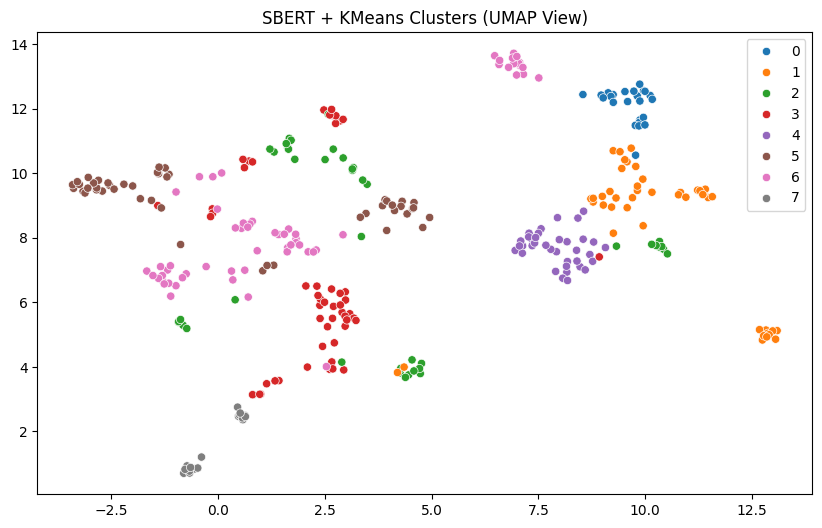

In [15]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
embedding_2d = reducer.fit_transform(X_sbert)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=labels_sbert, palette="tab10")
plt.title("SBERT + KMeans Clusters (UMAP View)")
plt.show()


In [16]:
# Add all cluster labels
df["tfidf_kmeans"] = labels_tfidf
df["sbert_kmeans"] = labels_sbert
df["sbert_hdbscan"] = labels_hdb

# Export to CSV
df.to_csv("intent_clustering_comparison.csv", index=False)
print("Saved: intent_clustering_comparison.csv")


Saved: intent_clustering_comparison.csv
